###Wind characteristics are the most important control in aeolian environments. Wind regime and sand transport potential play a crucial rule to determine the evolution and dynamics of aeolian processes and landforms. In this exercise, we will: (1) analyse wind data from a meteorological station and make wind roses; (2) use the Law of the Wall to determine the roughness length; and (3) calculate resultant drift potential, resultant drift direction and wind directional variability using Fryberger method.

# Wind roses
### Average 6-hourly wind velocities from 1957 to 2003 were acquired from the meteorological station in Dongsheng, Inner Mongolia. Wind directions were recorded in 16 directions. 1 to 16 represents wind from NNE, NE, ENE ... in the clockwise direction. So 22.5 degree intervals. 17 means no wind.

In [26]:
# install package for windrose
!pip install windrose

In [34]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import math
from math import pi

In [15]:
# read the data
df = pd.read_csv("https://raw.githubusercontent.com/Na-Leeds/BSc_Data_to_Insights_Aeolian/refs/heads/main/raw%20data%20wind%20Dongsheng.csv")

In [16]:
# check the first 10 rows of data
df.head(10)

,year,month,day,time,direction,speed
0,1957,1,1,2,10,3
1,1957,1,1,8,10,4
2,1957,1,1,14,11,3
3,1957,1,1,20,9,5
4,1957,1,2,2,17,0
5,1957,1,2,8,17,0
6,1957,1,2,14,16,6
7,1957,1,2,20,1,2
8,1957,1,3,2,1,3
9,1957,1,3,8,16,6


In [17]:
# summary statistics
df.describe()

,year,month,day,time,direction,speed
count,68659.000000,68659.000000,68659.000000,68659.000000,68659.000000,68659.000000
mean,1980.001398,6.523311,15.729067,11.000655,16.729023,3.258801
std,13.563690,3.448652,8.799926,6.708057,467.721023,2.228501
min,1957.000000,1.000000,1.000000,2.000000,1.000000,0.000000
25%,1968.000000,4.000000,8.000000,8.000000,8.000000,2.000000
50%,1980.000000,7.000000,16.000000,14.000000,10.000000,3.000000
75%,1992.000000,10.000000,23.000000,20.000000,14.000000,4.000000
max,2003.000000,12.000000,31.000000,20.000000,32766.000000,20.000000


In [18]:
# check data types
df.dtypes

,0
year,int64
month,int64
day,int64
time,int64
direction,int64
speed,int64


In [19]:
# check the size of data
df.shape

(68659, 6)

In [20]:
# df.loc[df['direction']>17]

In [21]:
# delete rows with odd direction
# df = df.drop(df[df['direction']>17].index)

In [22]:
# check the size of data again
#df.shape

In [23]:
# check data
df.min()

,0
year,1957
month,1
day,1
time,2
direction,1
speed,0


In [24]:
df.max()

,0
year,2003
month,12
day,31
time,20
direction,32766
speed,20


In [28]:
# create a new column with direction in degree
df['dir_compass'] = df['direction']*22.5

<Axes: >

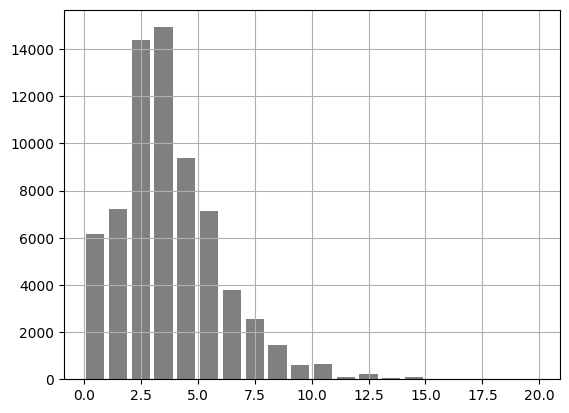

In [29]:
# plot histogram of wind speed
df['speed'].hist(bins = 20, rwidth=0.8, color = 'grey')

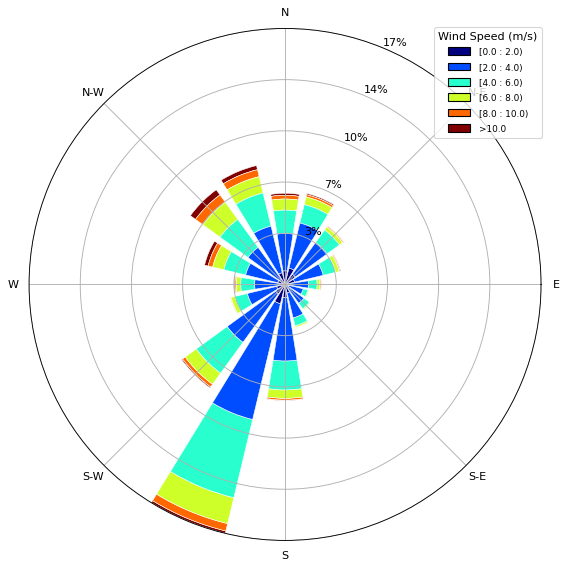

In [61]:
# plot wind roses
from windrose import WindroseAxes, plot_windrose

# plot windrose in bar mode, in percent
ax = WindroseAxes.from_ax()

ax.bar(df.dir_compass, df.speed, bins = np.array([0, 2, 4, 6, 8, 10]), normed=True, opening=0.8, cmap=cm.jet, linewidth=0.5, edgecolor='white')
ax.set_legend(title = 'Wind Speed (m/s)', loc='best')

# Format radius axis to percentages
import matplotlib.ticker as mtick
fmt = '%.0f%%'
yticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(yticks)

plt.show()

# check this link and choose your favorite colourmap: https://matplotlib.org/stable/gallery/color/colormap_reference.html




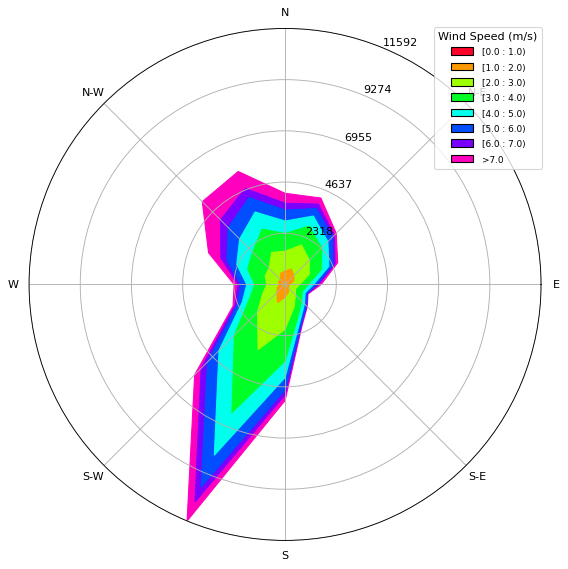

In [32]:
# plot windrose in filled mode, in bin limits
ax = WindroseAxes.from_ax()
ax.contourf(df.dir_compass, df.speed, bins=np.arange(0, 8, 1), cmap=cm.gist_rainbow)
ax.set_legend(title = 'Wind Speed (m/s)', loc='best')

# Format radius axis
fmt = '%.0f'
yticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(yticks)

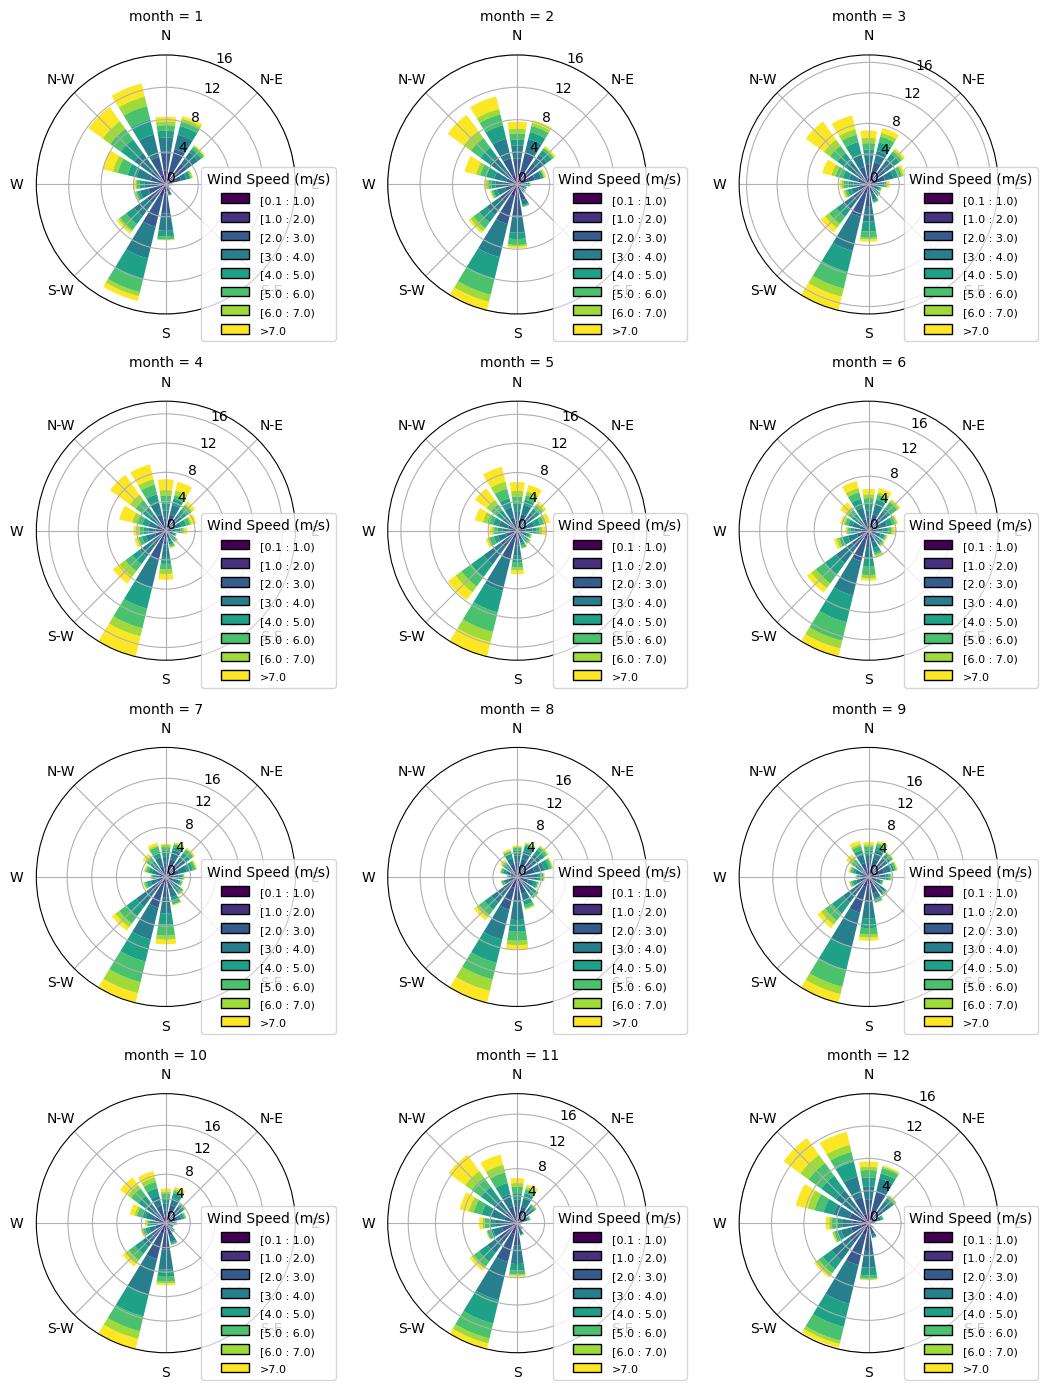

In [33]:
# plot windrose for each month
def plot_windrose_subplots(data, *, direction, var, color=None, **kwargs):
    """wrapper function to create subplots per axis"""
    ax = plt.gca()
    ax = WindroseAxes.from_ax(ax=ax)
    plot_windrose(direction_or_df=data[direction], var=data[var], ax=ax, **kwargs)


# this creates the raw subplot structure with a subplot per value in month.
g = sns.FacetGrid(
    data=df,
    # the column name for each level a subplot should be created
    col="month",
    # place a maximum of 3 plots per row
    col_wrap=3,
    subplot_kws={"projection": "windrose"},
    sharex=False,
    sharey=False,
    despine=False,
    height=3.5,
)

g.map_dataframe(
    plot_windrose_subplots,
    direction="dir_compass",
    var="speed",
    normed=True,
    # manually set bins, so they match for each subplot
    bins=(0.1, 1, 2, 3, 4, 5, 6, 7),
    calm_limit=0.1,
    kind="bar",
)

# make the subplots easier to compare, by having the same y-axis range
y_ticks = range(0, 20, 4)
for ax in g.axes:
    ax.set_legend(
        title='Wind Speed (m/s)', bbox_to_anchor=(1.15, -0.1), loc="lower right"
    )
    ax.set_rgrids(y_ticks, y_ticks)

# adjust the spacing between the subplots to have sufficient space between plots
plt.subplots_adjust(wspace=0.2)

# The Law of the Wall - wind profiles
###In order to caculate the threshold velocity at the height of 10.4 m, where cup anemometers were set up at the Dongsheng meteorological station, we will estimate the roughness length of the surface (z0) with wind velocity and direction data collected with a tower of 3-cup anemoanemometers at heights of 0.6m, 1.0m, 1.2m, 1.5m and 2.0m.


In [35]:
# load the data
df_wind = pd.read_csv("https://raw.githubusercontent.com/Na-Leeds/BSc_Data_to_Insights_Aeolian/refs/heads/main/windprofile.csv")

In [36]:
# check the data
df_wind.head()

,H,v1,v2,v3,v4,v5,v6,v7
0,0.6,4.399,5.131,4.874,5.918,5.973,4.999,5.475
1,1.0,4.887,5.642,5.253,6.390,6.406,5.377,5.818
2,1.2,5.038,5.751,5.265,6.480,6.536,5.346,5.974
3,1.5,5.095,5.856,5.533,6.802,6.831,5.673,6.210
4,2.0,5.346,6.177,5.766,7.190,7.146,5.929,6.481


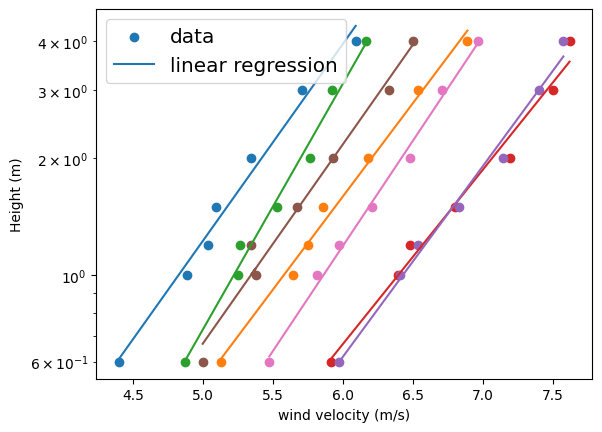

In [38]:
# There are seven sets of data. We will fit a linear regression between veolicities and ln(H) for each set of data.
from sklearn.metrics import r2_score

df_wind_results = pd.DataFrame(index = range(7), columns=['r_squared', 'shear_v', 'z0'])
plt.figure()
for idata in list(range(0,df_wind.shape[0],1)):

    # perform linear regression
    x_data = df_wind.iloc[:, idata+1]
    y_data = np.log(df_wind['H'])
    slope, intercept = np.polyfit(x_data, y_data, 1)

    # calculate predicted values using the regression equation
    y_predicted = slope * x_data + intercept

    # Calculate R-squared value
    r_squared = r2_score(y_data, y_predicted)
    shear_v = 0.4/slope
    z0 = np.exp(intercept)

    df_wind_results.iloc[idata, 0] = r_squared
    df_wind_results.iloc[idata, 1] = shear_v
    df_wind_results.iloc[idata, 2] = z0


    # Plot the data and regression line
    plt.scatter(x_data, df_wind['H'])
    plt.plot(x_data, np.exp(y_predicted))

# format figure
plt.yscale("log")
plt.xlabel('wind velocity (m/s)')
plt.ylabel('Height (m)')
plt.legend(["data","linear regression"], fontsize="x-large")
plt.show()


In [40]:
# show results
print(df_wind_results)

  r_squared   shear_v        z0
0  0.984991  0.342569  0.003574
1  0.991525  0.361876  0.002104
2  0.986164  0.274525  0.000497
3  0.983162  0.386915  0.001348
4   0.98863  0.353864    0.0007
5  0.980569  0.338737  0.001822
6  0.994256  0.320897  0.000673


In [43]:
# calculate shear velocity at the height = 10.4m where meteorological station is located. The threshold shear veolicity at the surface is 0.19, which is known.
threshold_shear_v = 0.19
z0_mean = df_wind_results['z0'].mean()

# caluclate threshold shear velocity at the height of 10.4m (height of cup anemometer for the meterological station)
shear_v_station = threshold_shear_v/0.4*math.log(10.4/z0_mean)
print(shear_v_station)

4.1911829178844


# Sand transport potential
### Sand drift potentials (DP), which reflect the relative amount of potential sand drift for a certain period of time, were evaluated by the Fryberger method (Fryberger, 1979).

In [44]:
# calculate drift potential for each direction
df['DP'] = df['speed']*df['speed']*(df['speed']-shear_v_station)*1/df.shape[0]

# change negative DP to zero
df.loc[df['DP']<0, 'DP'] = 0

# check DP
df['DP'].describe()

,DP
count,68659.000000
mean,0.000506
std,0.002274
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,0.092100


In [45]:
# summarise DP for each wind direction
df_DP = pd.DataFrame()
df_DP['dir'] = list(range(1, 17, 1))
df_DP['DP'] = np.nan

for dir in list(range(1, 17, 1)):
    DP_sum = df.loc[df['direction'] == dir, 'DP'].sum()
    df_DP.iloc[dir-1, 1] = DP_sum

print(df_DP)

    dir        DP
0     1  1.814419
1     2  0.677902
2     3  0.852349
3     4  0.580610
4     5  0.151256
5     6  0.183447
6     7  0.234306
7     8  1.258909
8     9  4.949640
9    10  2.232545
10   11  0.549408
11   12  1.124888
12   13  4.254379
13   14  8.045945
14   15  5.109282
15   16  2.697630


In [47]:
# add a column with directions in degree
df_DP['dir_compass'] = df_DP['dir']*22.5
print(df_DP)

    dir        DP  dir_compass
0     1  1.814419         22.5
1     2  0.677902         45.0
2     3  0.852349         67.5
3     4  0.580610         90.0
4     5  0.151256        112.5
5     6  0.183447        135.0
6     7  0.234306        157.5
7     8  1.258909        180.0
8     9  4.949640        202.5
9    10  2.232545        225.0
10   11  0.549408        247.5
11   12  1.124888        270.0
12   13  4.254379        292.5
13   14  8.045945        315.0
14   15  5.109282        337.5
15   16  2.697630        360.0


In [54]:
# cacluate resultant drift potential (RDP), remember compass direction is different from normal x,y direction
df_DP['DP_n'] = np.nan
df_DP['DP_e'] = np.nan
for i in list(range(0, 16, 1)):
    df_DP.iloc[i,3] =  df_DP.iloc[i,1] * math.cos(math.radians(df_DP.iloc[i, 2]))
    df_DP.iloc[i,4] =  df_DP.iloc[i,1] * math.sin(math.radians(df_DP.iloc[i, 2]))

RDP_n = df_DP['DP_n'].sum()
RDP_e = df_DP['DP_e'].sum()
RDP = math.sqrt(math.pow(df_DP['DP_n'].sum(), 2) + math.pow(df_DP['DP_e'].sum(), 2))
RDP_dir = math.degrees(math.atan2(RDP_n,RDP_e)) # direction of RDP is direction of wind blows to (not from)
RDP2DP = RDP/df_DP['DP'].sum()

print(RDP_n, RDP_e, RDP, RDP_dir, RDP2DP)

9.192499027427015 -13.779481663770532 16.564303586068295 146.2921520876781 0.4771248868353079


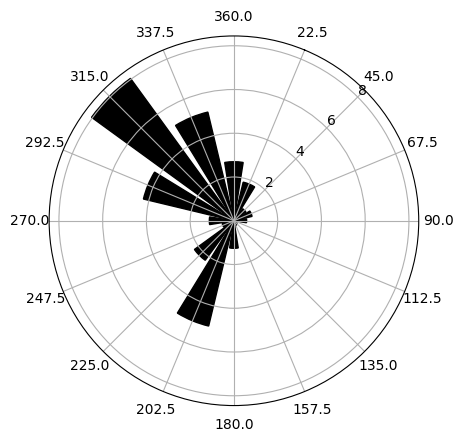

In [55]:
# Plot DP in polar plot
theta = np.linspace(0, 2*np.pi, 16, endpoint=False)
directions = df_DP['dir_compass']

ax = plt.subplot(polar=True)
ax.bar(theta, df_DP['DP'], width=2*pi/16*0.8, linewidth=1, edgecolor='k', alpha=1, color = 'k')

ax.set_xticks(theta)
ax.set_xticklabels(directions)
ax.set_yticks([2,4,6,8])
ax.set_yticklabels([2,4,6,8])

# set change in clockwise direction and zero at the north direction
ax.set_theta_offset(math.radians(45+22.5))
ax.set_theta_direction(-1)



In [56]:
# check outputs
df_DP

,dir,DP,dir_compass,DP_n,DP_e
0,1,1.814419,22.5,1.676304e+00,6.943480e-01
1,2,0.677902,45.0,4.793492e-01,4.793492e-01
2,3,0.852349,67.5,3.261797e-01,7.874676e-01
3,4,0.580610,90.0,3.555212e-17,5.806102e-01
4,5,0.151256,112.5,-5.788317e-02,1.397423e-01
5,6,0.183447,135.0,-1.297166e-01,1.297166e-01
6,7,0.234306,157.5,-2.164705e-01,8.966502e-02
7,8,1.258909,180.0,-1.258909e+00,1.541719e-16
8,9,4.949640,202.5,-4.572871e+00,-1.894145e+00
9,10,2.232545,225.0,-1.578648e+00,-1.578648e+00


In [94]:
# calculate DP for each month
df_DP['DP_Jan'] = np.nan
df_DP['DP_Feb'] = np.nan
df_DP['DP_Mar'] = np.nan
df_DP['DP_Apr'] = np.nan
df_DP['DP_May'] = np.nan
df_DP['DP_Jun'] = np.nan
df_DP['DP_Jul'] = np.nan
df_DP['DP_Aug'] = np.nan
df_DP['DP_Sep'] = np.nan
df_DP['DP_Oct'] = np.nan
df_DP['DP_Nov'] = np.nan
df_DP['DP_Dec'] = np.nan

# create dataframe with 16 rows (wind directions), and 12 coloumns (12 months)
df_DP_n = pd.DataFrame(index = range(16), columns=['Jan', 'Feb', 'Mar', 'Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
df_DP_e = pd.DataFrame(index = range(16), columns=['Jan', 'Feb', 'Mar', 'Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])

# create a dataframe with 12 rows (12 months) and 2 coloumns (resultant drift potential and its direction)
RDP_month = pd.DataFrame(index = range(12), columns=['RDP', 'Dir', 'DP', 'RDP2DP'])

for j in list(range(1,13,1)):
    df_month = df.loc[df['month'] == j]

    for i in list(range(1, 17, 1)):
        DP_sum = df_month.loc[df_month['direction'] == i, 'DP'].sum()
        df_DP.iloc[i-1,j+4] = DP_sum
        df_DP_n.iloc[i-1,j-1] = DP_sum * math.cos(math.radians(df_DP.iloc[i-1, 2]))
        df_DP_e.iloc[i-1,j-1] = DP_sum * math.sin(math.radians(df_DP.iloc[i-1, 2]))

# check results
RDP_month_n = df_DP_n.sum()
RDP_month_e = df_DP_e.sum()
RDP_month_DP = df_DP.sum().iloc[5:17]

for k in list(range(0, 12, 1)):
    RDP = math.sqrt(math.pow(RDP_month_n.iloc[k], 2) + math.pow(RDP_month_e.iloc[k], 2))
    Dir = math.degrees(math.atan2(RDP_month_n.iloc[k], RDP_month_e.iloc[k])) # direction of RDP is direction of wind blows to (not from)
    if Dir < 0:
        Dir = Dir + 180
    RDP_month.iloc[k,0] = RDP
    RDP_month.iloc[k,1] = Dir
    RDP_month.iloc[k,2] = RDP_month_DP.iloc[k]
    RDP_month.iloc[k,3] = RDP/RDP_month_DP.iloc[k]

print(RDP_month)

         RDP         Dir        DP    RDP2DP
0   1.798525  134.728928  2.500616  0.719233
1   1.838335  139.338916  2.837249  0.647929
2   2.412776  142.312124  4.276444  0.564202
3   2.930544  138.652713  6.292725  0.465703
4   1.670885  134.624354  4.343791  0.384661
5   0.673538  138.615433  2.564929  0.262595
6   0.598106   46.643148  1.552085  0.385357
7   0.580477   57.229313  1.329132  0.436734
8   0.480462   12.929708  1.532345  0.313547
9   0.992384  167.639218  2.071863  0.478982
10  2.054035  142.871612  2.853771  0.719762
11  1.975955  140.772992  2.561964  0.771266


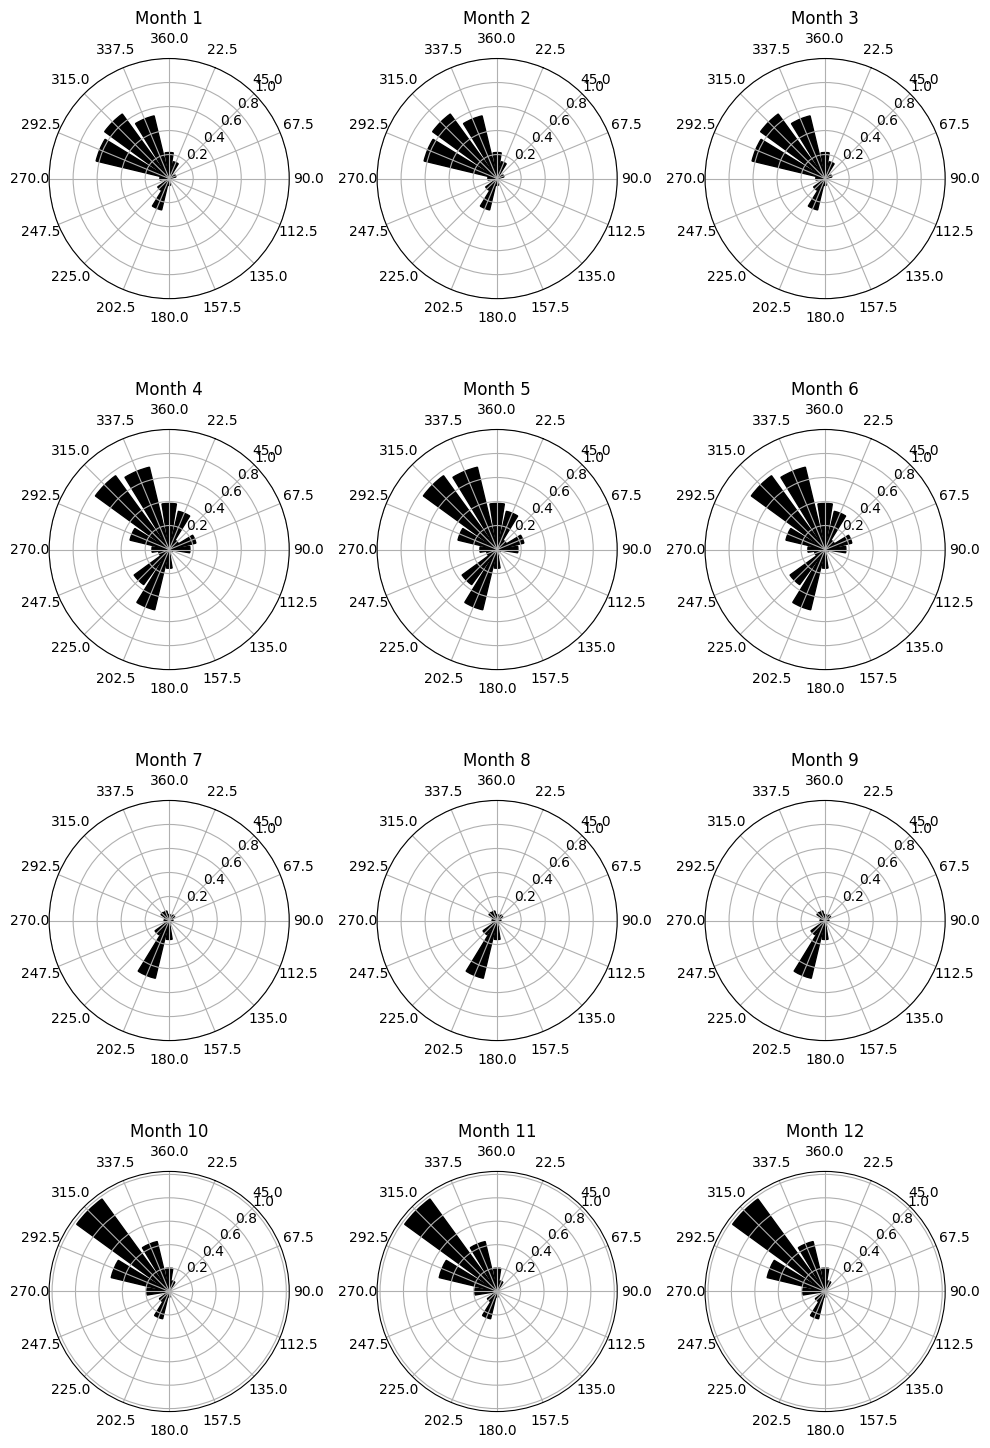

<Figure size 60000x5000 with 0 Axes>

In [60]:
# plot DP for each month
theta = np.linspace(0, 2*np.pi, 16, endpoint=False)
directions = df_DP['dir_compass']
fig, axs = plt.subplots(4, 3, subplot_kw = {'projection' : 'polar'}, figsize=(10, 15))
grid = plt.GridSpec(4, 3, wspace=0.2, hspace=1)
plt.figure(figsize=[600,50])
for j in range(4):
    for i in range(3):
        month = j*3 + i + 1
        axs[j,i].bar(theta, df_DP.iloc[: ,5+month-i], width=2*pi/16*0.8, linewidth=1, edgecolor='k', alpha=1, color = 'k')
        axs[j,i].set_xticks(theta)
        axs[j,i].set_xticklabels(directions)
        axs[j,i].set_yticks([0.2,0.4,0.6,0.8,1.0])
        axs[j,i].set_yticklabels([0.2,0.4,0.6,0.8,1.0])

        # set change in clockwise direction and zero at the north direction
        axs[j,i].set_theta_offset(math.radians(45+22.5))
        axs[j,i].set_theta_direction(-1)
        axs[j,i].title.set_text(f'Month {month}')

fig.tight_layout(h_pad=1, w_pad=1)

# Question: Comparing the drift potential roses with wind roses, what do you notice?